# Nonmarine vs. Marine Analysis  
#### Joshua Poirier, [NEOS](http://www.neosgeo.com)  
2016 SEG Machine Learning Contest  

## 1 Introduction  

This notebook analyzes the relationship between the Nonmarine vs. Marine log indicator (**NM_M** in the dataset) and its impact on facies.  The idea is that different facies should have nearly all observations belonging to either the *nonmarine* class, or the *marine* class.  If this is the case, it may be prudent to develop two separate classifiers split on the Nonmarine vs. Marine indicator.  This may help reduce misclassification (observations with a *nonmarine* indicator may only be classified as a *nonmarine* facies, likewise for *marine*).  Similarly, the machine learning algorithm may have already "learned" this - in which case the results will be equal or worse.

After loading the data, I will examine the distribution of the **NM_M** feature across each facies.  I will then determine which facies may be considered *nonmarine* origin, and which facies *marine* origin.  I will then apply the Support Vector Machine algorithm to **A - the entire dataset** (as with *jpoirier001.ipynb*), and **B - nonmarine and marine separately** to assess any improvement in predictive accuracy.  Here, accuracy will be measured by the average **F1 score** across all classes when applied to the **Newby** well - which will be considered a blind test and not included when training the model.

First, let's load packages required to perform our analysis.

In [2]:
# visualization packages
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

# machine learning packages
library(caret)
library(e1071)

## 2 Exploring the dataset  

First let's load the data and look at the first few rows.  The data is contained in the file *facies_vectors.csv* and contains five wireline log measurements, two indicator variables, and a facies label at half-foot increments.

In [3]:
# load data
fname <- "../facies_vectors.csv"
data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",6), "factor", "numeric"))

# display first five rows of data set and it's dimensions
head(data)
paste(dim(data)[1], "rows x", dim(data)[2], "columns")

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915
3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894


[1] "4149 rows x 11 columns"

In [4]:
# training and validation maybe?
blind <- data[data$Well.Name == 'NEWBY',]
data <- data[data$Well.Name != 'NEWBY',]

This data is from the Panoma Council Grove Field (predominantly gas reservoir) over 2700 sq mi in SW Kansas.  The dataset is from nine wells with 4149 samples.  Each sample consists of seven predictor variables and a rock facies.  The validation (test) data have 830 samples from two wells having the same seven predictor variables.  Facies are based on examination of cores from the nine wells taken vertically at half-foot intervals.  The predictor variables include five wireline log measurements and two geologic constraining variables that are derived from geologic knowledge and are sampled at the same half-foot rate.  

The seven predictor variables are:

* GR - Gamma ray  
* ILD_log10 - Resistivity logging  
* PE - Photoelectric effect (some wells are missing this log)  
* DeltaPhi - Neutron-density porosity difference  
* PHIND - Average neutron-density porosity  

The two geologic constraining variables are:  

* NM_M - nonmarine-marine indicator  
* RELPOS - Relative position  

The nine discrete facies (classes of rock) are:  

1. Nonmarine sandstone  
2. Nonmarine coarse siltstone  
3. Nonmarine fine siltstone  
4. Marine siltstone and shale  
5. Mudstone (limestone)  
6. Wackestone (limestone)  
7. Dolomite  
8. Pckstone-grainstone (limestone)  
9. Phylloid-algal bafflestone (limestone)  

These facies are not discrete and can gradually blend into one another.  Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels, and their approximate neighbors.  


Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8  

Now let's define a colormap for the facies such that they are represented by consistent colors in this tutorial.  We'll also take a peek at the statistical distribution of the input variables.

In [5]:
# 1=sandstone, 2=c_siltstone, 3=f_siltstone, 4=marine_silt_shale, 5=mudstone, 
# 6=wackestone, 7=dolomite, 8=packestone, 9=bafflestone

facies_colors <- c('#F4D03F', '#F5B041', '#DC7633', '#6E2C00', '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D')
facies_labels <- c('SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS')

summary(data)

     Facies      Formation             Well.Name       Depth     
 2      :842   C LM   : 594   CROSS H CATTLE:501   Min.   :2574  
 3      :700   A1 LM  : 509   SHRIMPLIN     :471   1st Qu.:2806  
 8      :630   A1 SH  : 379   ALEXANDER D   :466   Median :2931  
 6      :486   C SH   : 351   LUKE G U      :461   Mean   :2903  
 1      :268   B5 LM  : 319   SHANKLE       :449   3rd Qu.:3008  
 5      :268   B1 SH  : 303   KIMZEY A      :439   Max.   :3138  
 (Other):492   (Other):1231   (Other)       :899                 
       GR           ILD_log10           DeltaPHI           PHIND      
 Min.   : 10.15   Min.   :-0.02595   Min.   :-21.832   Min.   : 0.55  
 1st Qu.: 45.57   1st Qu.: 0.48900   1st Qu.:  1.700   1st Qu.: 8.55  
 Median : 65.68   Median : 0.63500   Median :  4.369   Median :12.17  
 Mean   : 65.46   Mean   : 0.65765   Mean   :  4.519   Mean   :13.40  
 3rd Qu.: 80.20   3rd Qu.: 0.82900   3rd Qu.:  7.600   3rd Qu.:16.24  
 Max.   :361.15   Max.   : 1.80000   Max.   : 

Looking at the statistical summary of the input variables, it can be seen that all but the **PE** (photoelectric effect) inputs have no **NA**'s listed.  For this tutorial, we will drop the feature vectors that do not have a valid **PE** entry.

In [6]:
PE_mask <- complete.cases(data)
data <- data[PE_mask,]
paste(dim(data)[1], "rows x", dim(data)[2], "columns")

[1] "2769 rows x 11 columns"

Out of the original 4149 samples, we will be training our model on 2769 samples.  Now let's build some familiar log plots!

In [7]:
logplot <- function(x, incl_fac=TRUE, incl_pred=FALSE) {
    # GR gamma ray track
    g1 <- ggplot(x) + theme_economist_white(gray_bg=T) + 
        scale_y_continuous(lim=c(0,400), breaks=seq(0,400,100), labels=c("0"="0","100"="","200"="200","300"="","400"="400")) +
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="Depth", y="GR") +
        geom_bar(stat="identity", data=x, aes(x=Depth, y=GR, fill=GR, alpha=0.5), width=0.5) +
        geom_line(aes(x=Depth, y=GR), lwd=.5, col='black') +
        scale_fill_continuous(limits=c(0,225), low="yellow", high="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.5), legend.position="none",
             axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"))
    g1 <- switch_axis_position(g1, 'x')
    
    # ILD resistivity track (transform it back to actual units)
    g2 <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_log10(lim=c(0.1,50), breaks=c(.1,.2,.4,.6,.8,1,2,4,6,8,10,20,40), 
                      labels=c(".1"=".1",".2"="",".4"="",".6"="",".8"="",
                               "1"="1","2"="","4"="","6"="","8"="","10"="10",
                              "20"="","40"="")) + 
        scale_x_continuous(trans="reverse") + 
        coord_flip() + labs(title="", x="", y="ILD") +
        geom_line(aes(x=Depth, y=10^ILD_log10), lwd=.5, col="skyblue4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g2 <- switch_axis_position(g2, 'x')
    
    # DeltaPhi track
    g3 <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-20,20), breaks=seq(-20,20,10),labels=c("-20"="-20","-10"="","0"="0","10"="","20"="20")) + 
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="", y="DeltaPhi") +
        geom_line(aes(x=Depth, y=DeltaPHI), lwd=.5, col="seagreen4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g3 <- switch_axis_position(g3, 'x')
    
    # PHIND neutron porosity track
    g4 <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,50), breaks=c(0,15,30,45)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PHIND") +
        geom_line(aes(x=Depth, y=PHIND), lwd=.5, col="firebrick") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g4 <- switch_axis_position(g4, 'x')
    
    # PE photoelectric effect track
    g5 <- ggplot(x) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,8), breaks=c(0,2,4,6,8)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PE") +
        geom_line(aes(x=Depth, y=PE), lwd=.5, col="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g5 <- switch_axis_position(g5, 'x')
    
    x$ones <- rep(1, nrow(x))
    # build a facies track if we are to include
    if (incl_fac) {
        g6 <- ggplot(x) + theme_economist_white(gray_bg=T) +
            scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("0"="", "1"="")) + scale_x_continuous(trans="reverse") +
            coord_flip() + labs(title="", x="", y="Facies") +
            geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=Facies), width=0.5) +
            scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
            theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6))
    }
    
    # build a prediction track if we are to include
    if (incl_pred) {
        # build Predicted Facies track
        g7 <- ggplot(x) + theme_economist_white(gray_bg=T) +
            scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("0"="", "1"="")) + scale_x_continuous(trans="reverse") +
            coord_flip() + labs(title="", x="", y="Predicted") +
            geom_bar(stat="identity", data=x, aes(x=Depth, y=ones, fill=Predicted), width=0.5) +
            scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
            theme(legend.position="right", legend.text=element_text(size=6), legend.title=element_blank()) +
            theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6))
        g7 <- switch_axis_position(g7, 'x')
        
        # finish off Facies track with no legend if we are to include
        if (incl_fac) {
            g6 <- g6 + theme(legend.position="none")
            g6 <- switch_axis_position(g6, 'x')
            
            # bring all the tracks together as a grid
            g <- plot_grid(g1, g2, g3, g4, g5, g6, g7, ncol=7, rel_widths=c(4,3,3,3,3,2,5))
        }
        else {
            # bring all the tracks together as a grid
            g <- plot_grid(g1, g2, g3, g4, g5, g7, ncol=6, rel_widths=c(4,3,3,3,3,5))
        }
        
        ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(x$Well.Name[1], size=10)
    }
    else {
        if (incl_fac) {
            # finish off Facies track with a legend
            g6 <- g6 + theme(legend.position="right", legend.text=element_text(size=6), legend.title=element_blank())
            g6 <- switch_axis_position(g6, 'x')
            
            # bring all the tracks together as a grid
            g <- plot_grid(g1, g2, g3, g4, g5, g6, ncol=6, rel_widths=c(4,3,3,3,3,6))
        }
        else {
            # bring all the tracks together as a grid
            g <- plot_grid(g1, g2, g3, g4, g5, ncol=5, rel_widths=c(4,3,3,3,3))
        }
        
        ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(x$Well.Name[1], size=10)    
    }
}

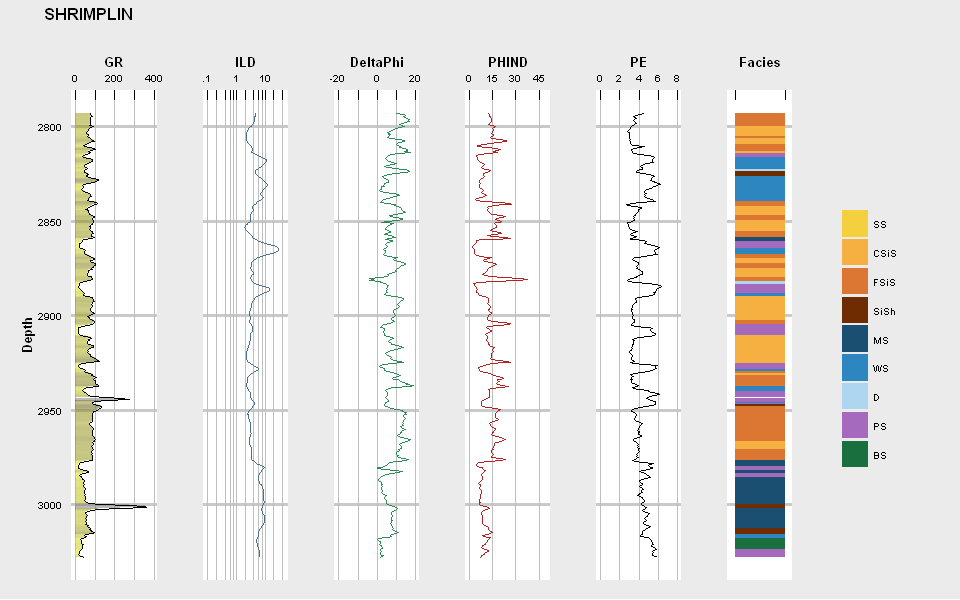

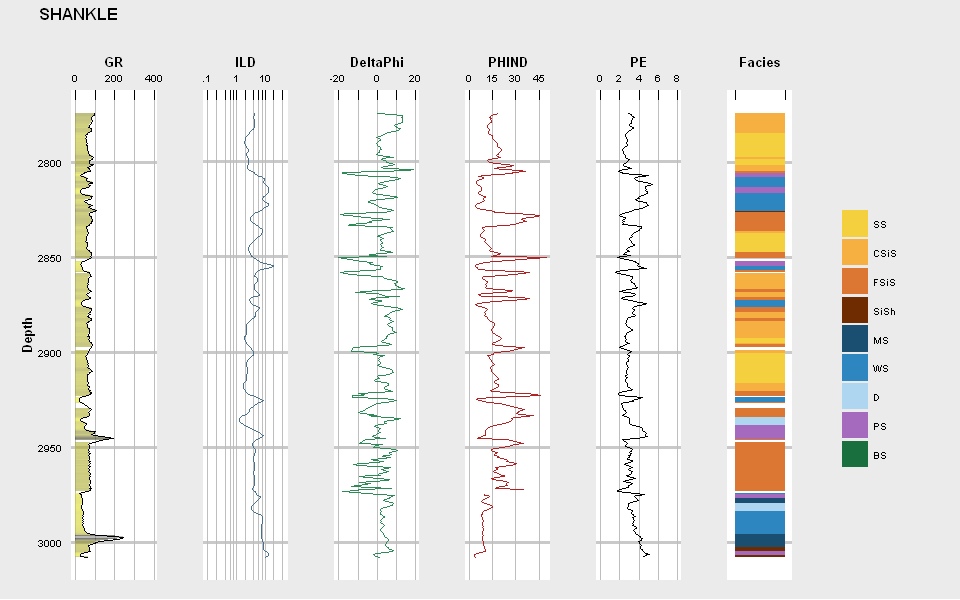

In [8]:
options(repr.plot.width=8, repr.plot.height=5)

# plot logs for the Shrimplin and Shankle wells
logplot(data[data$Well.Name == "SHRIMPLIN",])
logplot(data[data$Well.Name == "SHANKLE",])

## 3 Too marine or not too marine?  

Now let's examine the distribution of facies for both observations featuring a *nonmarine* indicator as well as a *marine* indicator.  To do this, let's build a histogram faceted on the **NM_M** variable.

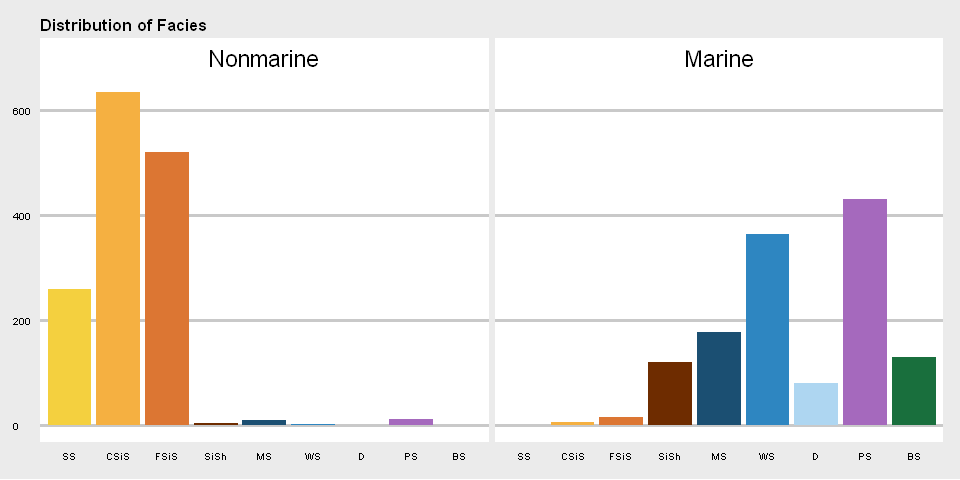

In [9]:
options(repr.plot.width=8, repr.plot.height=4)

# modify the NM_M factors to be a string - more descriptive and plots nicer
levels(data$NM_M)[levels(data$NM_M)=="1"] <- "Nonmarine"
levels(data$NM_M)[levels(data$NM_M)=="2"]   <- "Marine"

# build histogram faceted on the NM_M (nonmarine vs marine) feature
g <- ggplot(data, aes(x=Facies)) + theme_economist_white(gray_bg=T) + 
        facet_grid(. ~ NM_M) +
        geom_bar(aes(x=Facies, fill=Facies)) + labs(title="Distribution of Facies", x="", y="") +
        scale_x_discrete(labels=facies_labels) +
        scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
        theme(legend.position="none", legend.title=element_blank(), legend.text=element_text(size=6),
             axis.text=element_text(size=6), plot.title=element_text(size=10), axis.title=element_blank(),
             axis.ticks.x=element_blank())

g

That's a pretty interesting visual.  The **SS**, **CSiS**, and **FSiS** facies appear to be **nonmarine**; while the remaining facies appear to be **marine**.  There do seem to be a handful of cross-classifications - let's make a table to quantify the percentage of observations not following this trend.

In [10]:
# modify the factor levels for facies to be more descriptive
levels(data$Facies)[levels(data$Facies)=="1"] <- "SS"
levels(data$Facies)[levels(data$Facies)=="2"]   <- "CSiS"
levels(data$Facies)[levels(data$Facies)=="3"]   <- "FSiS"
levels(data$Facies)[levels(data$Facies)=="4"]   <- "SiSh"
levels(data$Facies)[levels(data$Facies)=="5"]   <- "MS"
levels(data$Facies)[levels(data$Facies)=="6"]   <- "WS"
levels(data$Facies)[levels(data$Facies)=="7"]   <- "D"
levels(data$Facies)[levels(data$Facies)=="8"]   <- "PS"
levels(data$Facies)[levels(data$Facies)=="9"]   <- "BS"

# count observations of facies which are nonmarine or marine
t <- table(data$Facies, data$NM_M == "Marine")

# calculate those counts as percentages
nm_percent <- round(100 * t[,1] / (t[,1] + t[,2]),0)
m_percent <- round(100 * t[,2] / (t[,1] + t[,2]),0)
t <- as.table(cbind(t[,1], t[,2], nm_percent, m_percent))

# format the table and output
dimnames(t)[[2]] <- c('# Nonmarine', '# Marine', '% Nonmarine', '% Marine')
t

     # Nonmarine # Marine % Nonmarine % Marine
SS           259        0         100        0
CSiS         634        6          99        1
FSiS         519       16          97        3
SiSh           5      121           4       96
MS            11      178           6       94
WS             2      364           1       99
D              1       81           1       99
PS            12      430           3       97
BS             0      130           0      100

**MS** - Mudstone is the facies with the most uncertainty here.  Of the 189 observations of the **MS** facies, 11 (6%) were considered nonmarine.  It's probably safe to call **SS**, **CSiS**, and **FSiS** all nonmarine, and the remaining facies marine.  How many of the observations overall do not fall into this ordering of the data?

In [11]:
# sum up how many correctly/incorrectly fall under our "rule"
nm_m_true <- t[1,1] + t[2,1] + t[3,1] + t[4,2] + t[5,2] + t[6,2] + t[7,2] + t[8,2] + t[9,2]
nm_m_false <- t[1,2] + t[2,2] + t[3,2] + t[4,1] + t[5,1] + t[6,1] + t[7,1] + t[8,1] + t[9,1]

# percentage of observations not falling under our "rule*
paste(round(100 * nm_m_false / (nm_m_true + nm_m_false),2), "%")

[1] "1.91 %"

Less than 2% of observations fail our *rule*.  Let's move forward to applying some Support Vector Machines to our data!  

## 4 A support vector machine classifier  

As in the previous notebook *jpoirier001.ipynb*, let's build a Support Vector Machine classifier.  First, we'll build a classifier and tune the results.  Second, we'll build two classifiers (one for **nonmarine** indicators, one for **marine**).  

### 4.1 Support vector machine with all data  

This workflow will be very similar to that of *jpoirier001.ipynb*.  Ultimately we expect the same results.

In [47]:
## HELPER FUNCTIONS
## ################################################################################################

# list of adjacent facies
adjacent_facies <- list(as.list(c(2)), as.list(c(1,3)), 
                        as.list(c(2)), as.list(c(5)), 
                        as.list(c(4,6)), as.list(c(5,7,8)), 
                        as.list(c(6,8)), as.list(c(6,7,9)), 
                        as.list(c(7,8)))

# function to calculate the confusion matrix which includes adjacent facies as correctly classified
adj_cm_table <- function(cm_table) {    
    adj_cm_table <- cm_table
    
    # loop through facies to build adjacent facies confusion matrix
    for (i in 1:9) {
        cor <- cm_table[i,i]

        # move adjacently correct facies into correct facies
        for (j in 1:length(adjacent_facies[[i]])) {
            cor <- cor + cm_table[adjacent_facies[[i]][[j]],i]
            adj_cm_table[adjacent_facies[[i]][[j]],i] <- 0
        }
        adj_cm_table[i,i] <- cor
    }
    
    # return adjacently corrected confusion matrix
    adj_cm_table
}

# function to display a confusion matrix
#   replaces the integer facies with facies shortnames first
disp_cm <- function(cm) {
    dimnames(cm)$Prediction <- facies_labels
    dimnames(cm)$Reference <- facies_labels
    print(cm)
}

# cm - confusion matrix either as a confusionMatrix object or table object
# x - the data used, from this we calculate how many observations (support) for each facies
accuracy_metrics <- function(cm, x) {
    # if given confusion matrix (cm) is a confusionMatrix object
    if (class(cm) == "confusionMatrix") {
        df <- data.frame("Facies" = facies_labels,
                        "Precision" = cm[["byClass"]][,5],
                        "Recall" = cm[["byClass"]][,6],
                        "F1" = cm[["byClass"]][,7],
                        "Support" = as.matrix(table(x$Facies)))
        df[,-1] <- round(df[,-1],2)
        rownames(df) <- NULL
    }
    # if given confusion matrix is a table object
    else if (class(cm) == "table") {
       # initialize vectors for precision, recall, and f1 metrics with zeros
        prec <- rep(0,9)
        recall <- rep(0,9)
        f1 <- rep(0,9)

        # loop through facies to compute precision, recall, and f1 for each facies
        beta <- 1
        for (i in 1:9) {
            prec[i] <- cm[i,i] / sum(cm[i,])
            recall[i] <- cm[i,i] / sum(cm[,i])
            f1[i] <- (1 + beta^2) * prec[i] * recall[i] / ((beta^2 * prec[i]) + recall[i])
        }
        
        # calculate model metrics for precision, recall, and f1 and output
        df <- data.frame(Facies=facies_labels, 
                         Precision=prec, 
                         Recall=recall, 
                         F1=f1, 
                         Support=as.matrix(table(x$Facies)))

        # round values to two digits
        df[,-1] <- round(df[,-1],2)
    }
    
    # average F1 score across all classes
    print(paste0("Overall F1-score of: ", round(mean(df$F1, na.rm=T),2)))
    print("Accuracy metrics:")
    df
}

In [13]:
set.seed(1234)

# split into training and test data sets
feature_vectors <- data[, c("Facies", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M", "RELPOS")]
trainIndex <- createDataPartition(feature_vectors$Facies, p=.8, list=F, times=1)
x_train <- feature_vectors[trainIndex,]
x_test <- feature_vectors[-trainIndex,]

set.seed(3124)

# calculates models for a variety of hyperparameters - this will take a few minutes
tune.out <- tune(svm, Facies ~ ., data=x_train, 
                 kernel="radial",
                 ranges=list(cost=c(.01,1,5,10,20,50,100,1000,5000,10000),
                            gamma=c(.0001,.001,.01,1,10)))

# predict facies using the best model
cv_predictions <- predict(tune.out$best.model, newdata=x_test)

## PART ONE: Confusion matrix for facies classification
"Facies classification confusion matrix:"
cv_cm <- confusionMatrix(cv_predictions, x_test$Facies)
disp_cm(as.matrix(cv_cm[["table"]]))

## PART TWO: Confusion matrix for adjacent facies classification
"Adjacent facies classification confusion matrix:"
cv_adj <- adj_cm_table(as.matrix(cv_cm[["table"]]))
disp_cm(cv_adj)

[1] "Facies classification confusion matrix:"

          Reference
Prediction SS CSiS FSiS SiSh MS WS  D PS BS
      SS   40   11    0    0  0  0  0  0  0
      CSiS 10   95   18    0  1  1  1  0  0
      FSiS  1   22   87    1  0  0  0  5  0
      SiSh  0    0    2   17  1  5  0  0  0
      MS    0    0    0    2 24  3  0  1  0
      WS    0    0    0    2  6 59  2 10  0
      D     0    0    0    1  0  0  9  2  0
      PS    0    0    0    2  5  5  2 70  0
      BS    0    0    0    0  0  0  2  0 26


[1] "Adjacent facies classification confusion matrix:"

          Reference
Prediction  SS CSiS FSiS SiSh  MS  WS   D  PS  BS
      SS    50    0    0    0   0   0   0   0   0
      CSiS   0  128    0    0   1   1   1   0   0
      FSiS   1    0  105    1   0   0   0   5   0
      SiSh   0    0    2   19   0   5   0   0   0
      MS     0    0    0    0  31   0   0   1   0
      WS     0    0    0    2   0  67   0   0   0
      D      0    0    0    1   0   0  13   0   0
      PS     0    0    0    2   5   0   0  82   0
      BS     0    0    0    0   0   0   2   0  26


Now let's apply the model to our blind data set an output the confusion matrices and accuracy metrics!

In [25]:
# modify the factor levels for facies to be more descriptive
levels(blind$Facies)[levels(blind$Facies)=="1"] <- "SS"
levels(blind$Facies)[levels(blind$Facies)=="2"]   <- "CSiS"
levels(blind$Facies)[levels(blind$Facies)=="3"]   <- "FSiS"
levels(blind$Facies)[levels(blind$Facies)=="4"]   <- "SiSh"
levels(blind$Facies)[levels(blind$Facies)=="5"]   <- "MS"
levels(blind$Facies)[levels(blind$Facies)=="6"]   <- "WS"
levels(blind$Facies)[levels(blind$Facies)=="7"]   <- "D"
levels(blind$Facies)[levels(blind$Facies)=="8"]   <- "PS"
levels(blind$Facies)[levels(blind$Facies)=="9"]   <- "BS"

"PART ONE: Facies classification"
blind_predictions <- predict(tune.out$best.model, newdata=blind[,c(-2,-3,-4)])
blind_cm <- confusionMatrix(blind_predictions, blind$Facies)
disp_cm(as.matrix(blind_cm[["table"]]))
accuracy_metrics(blind_cm, blind)

"PART TWO: Adjacent facies classification"
"Facies classification accuracy metrics"
blind_adj <- adj_cm_table(as.matrix(blind_cm[["table"]]))
disp_cm(blind_adj)
accuracy_metrics(cv_cm, x_test)

[1] "PART ONE: Facies classification"

          Reference
Prediction SS CSiS FSiS SiSh MS WS  D PS BS
      SS    0   20    4    0  0  0  0  0  0
      CSiS  0   49   29    0  1  1  0  1  0
      FSiS  0   27   43    4  1  4  0  6  0
      SiSh  0    0    0   42  4  5  0  0  2
      MS    0    0    0    2  1 32  0  5  0
      WS    0    0    0    5  9 10  0  4  4
      D     0    0    0    0  0  0  0  2  0
      PS    0    2    4    5 12 42 16 38 25
      BS    0    0    0    0  0  2  0  0  0
[1] "Overall F1-score of: 0.4"
[1] "Accuracy metrics:"


Facies,Precision,Recall,F1,Support
SS,0.00,NA,NA,0
CSiS,0.60,0.50,0.55,98
FSiS,0.51,0.54,0.52,80
SiSh,0.79,0.72,0.76,58
MS,0.02,0.04,0.03,28
WS,0.31,0.10,0.16,96
D,0.00,0.00,NaN,16
PS,0.26,0.68,0.38,56
BS,0.00,0.00,NaN,31


[1] "PART TWO: Adjacent facies classification"

[1] "Facies classification accuracy metrics"

          Reference
Prediction SS CSiS FSiS SiSh MS WS  D PS BS
      SS    0    0    4    0  0  0  0  0  0
      CSiS  0   96    0    0  1  1  0  1  0
      FSiS  0    0   72    4  1  4  0  6  0
      SiSh  0    0    0   44  0  5  0  0  2
      MS    0    0    0    0 14  0  0  5  0
      WS    0    0    0    5  0 84  0  0  4
      D     0    0    0    0  0  0 16  0  0
      PS    0    2    4    5 12  0  0 44  0
      BS    0    0    0    0  0  2  0  0 25
[1] "Overall F1-score of: 0.77"
[1] "Accuracy metrics:"


Facies,Precision,Recall,F1,Support
SS,0.78,0.78,0.78,51
CSiS,0.75,0.74,0.75,128
FSiS,0.75,0.81,0.78,107
SiSh,0.68,0.68,0.68,25
MS,0.80,0.65,0.72,37
WS,0.75,0.81,0.78,73
D,0.75,0.56,0.64,16
PS,0.83,0.80,0.81,88
BS,0.93,1.00,0.96,26


These results are consistent with what we observed in *jpoirier001.ipynb* - an overall F1 score of 0.4 and 0.77 for Facies and Adjacent Facies classification respectively.  

### 4.2.1 Support vector machine with nonmarine data  

Now let's subset the training data to only include observations with a nonmarine indicator.  From this, I will build a support vector machine model.  We will perform cross-validation again to see if the optimal model parameters are different for this subset of data.  We'll wait to do the adjacent facies classification accuracy analysis once we bring these classifications back together with the marine classifications.

In [54]:
# subset data - drop "marine" levels and also no longer train using NM_M channel since we only have one value
nm_feature_vectors <- droplevels(feature_vectors[feature_vectors$NM_M == "Nonmarine" &
                                      feature_vectors$Facies %in% c("SS", "CSiS", "FSiS"),-7])

# split into training and cross-validation
set.seed(3124)
nm_trainIndex <- createDataPartition(nm_feature_vectors$Facies, p=.8, list=F, times=1)
nm_x_train <- nm_feature_vectors[nm_trainIndex,]
nm_x_test <- nm_feature_vectors[-nm_trainIndex,]

# calculates models for a variety of hyperparameters - this will take a few minutes
nm_tune.out <- tune(svm, Facies ~ ., data=nm_x_train, 
                 kernel="radial",
                 ranges=list(cost=c(.01,1,5,10,20,50,100,1000,5000,10000),
                            gamma=c(.0001,.001,.01,1,10)))
summary(nm_tune.out)

# predict facies using the best model
nm_cv_predictions <- predict(nm_tune.out$best.model, newdata=nm_x_test)

## PART ONE: Confusion matrix for facies classification
"Facies classification confusion matrix:"
nm_cv_cm <- confusionMatrix(nm_cv_predictions, nm_x_test$Facies)
print(as.matrix(nm_cv_cm[["table"]]))


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    5     1

- best performance: 0.1908166 

- Detailed performance results:
    cost gamma     error dispersion
1  1e-02 1e-04 0.5512343 0.03163411
2  1e+00 1e-04 0.5512343 0.03163411
3  5e+00 1e-04 0.5309036 0.02981048
4  1e+01 1e-04 0.5017233 0.04100947
5  2e+01 1e-04 0.4513973 0.04280660
6  5e+01 1e-04 0.3895668 0.04841838
7  1e+02 1e-04 0.3922683 0.04295195
8  1e+03 1e-04 0.3453656 0.03622960
9  5e+03 1e-04 0.3480515 0.03436988
10 1e+04 1e-04 0.3515991 0.03959831
11 1e-02 1e-03 0.5512343 0.03163411
12 1e+00 1e-03 0.5026083 0.03988109
13 5e+00 1e-03 0.3895591 0.04593555
14 1e+01 1e-03 0.3887285 0.04055643
15 2e+01 1e-03 0.3816410 0.04816919
16 5e+01 1e-03 0.3533458 0.03854425
17 1e+02 1e-03 0.3506986 0.03504697
18 1e+03 1e-03 0.3374631 0.03777764
19 5e+03 1e-03 0.3242121 0.03736446
20 1e+04 1e-03 0.3250893 0.03928614
21 1e-02 1e-02 0.5512343 0.03163411
22 1e+00 1e-02 0.3692750 

[1] "Facies classification confusion matrix:"

          Reference
Prediction  SS CSiS FSiS
      SS    35    4    0
      CSiS  15  104   16
      FSiS   1   18   87


If we recall *jpoirier001.ipynb*, the cross-validation showed best parameters of cost 10 and gamma 1.  We observe here best parameters of cost 5 and gamma 1 (although, the error levels for each are very close).  It is noteworthy that our best performance has improved from 0.2475297 in *jpoirier001.ipynb* to 0.1908166 for nonmarine classifications.  What about marine?

### 4.2.2 Support vector machine with marine data  

Now let's subset the training data to only include observations with a marine indicator. From this, I will build a support vector machine model. We will perform cross-validation again to see if the optimal model parameters are different for this subset of data.

In [55]:
# subset data - drop "nonmarine" levels and also no longer train using NM_M channel since we only have one value
m_feature_vectors <- droplevels(feature_vectors[feature_vectors$NM_M == "Marine" &
                                      feature_vectors$Facies %in% c("SiSh", "MS", "WS", "D", "PS", "BS"),-7])

# split into training and cross-validation
set.seed(3124)
m_trainIndex <- createDataPartition(m_feature_vectors$Facies, p=.8, list=F, times=1)
m_x_train <- m_feature_vectors[m_trainIndex,]
m_x_test <- m_feature_vectors[-m_trainIndex,]

# calculates models for a variety of hyperparameters - this will take a few minutes
m_tune.out <- tune(svm, Facies ~ ., data=m_x_train, 
                 kernel="radial",
                 ranges=list(cost=c(.01,1,5,10,20,50,100,1000,5000,10000),
                            gamma=c(.0001,.001,.01,1,10)))
summary(m_tune.out)

# predict facies using the best model
m_cv_predictions <- predict(m_tune.out$best.model, newdata=m_x_test)

## PART ONE: Confusion matrix for facies classification
"Facies classification confusion matrix:"
m_cv_cm <- confusionMatrix(m_cv_predictions, m_x_test$Facies)
print(as.matrix(m_cv_cm[["table"]]))


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    5     1

- best performance: 0.2506868 

- Detailed performance results:
    cost gamma     error dispersion
1  1e-02 1e-04 0.6708242 0.03281789
2  1e+00 1e-04 0.6708242 0.03281789
3  5e+00 1e-04 0.6708242 0.03281789
4  1e+01 1e-04 0.6315476 0.05430612
5  2e+01 1e-04 0.5453938 0.05752132
6  5e+01 1e-04 0.5367582 0.06444069
7  1e+02 1e-04 0.4898810 0.06566294
8  1e+03 1e-04 0.4659707 0.06404152
9  5e+03 1e-04 0.4611905 0.06686358
10 1e+04 1e-04 0.4621520 0.06554248
11 1e-02 1e-03 0.6708242 0.03281789
12 1e+00 1e-03 0.6334615 0.05409037
13 5e+00 1e-03 0.5367674 0.06357036
14 1e+01 1e-03 0.4908333 0.06563223
15 2e+01 1e-03 0.4755586 0.06708216
16 5e+01 1e-03 0.4678938 0.06955061
17 1e+02 1e-03 0.4621154 0.06885379
18 1e+03 1e-03 0.4563645 0.05971992
19 5e+03 1e-03 0.4458425 0.05120021
20 1e+04 1e-03 0.4525641 0.05573591
21 1e-02 1e-02 0.6708242 0.03281789
22 1e+00 1e-02 0.4841392 

[1] "Facies classification confusion matrix:"

          Reference
Prediction SiSh MS WS  D PS BS
      SiSh   19  5  3  0  0  0
      MS      0 14  4  0  3  0
      WS      0  6 48  0 12  0
      D       0  1  1 11  2  1
      PS      5  9 14  4 68  0
      BS      0  0  2  1  1 25


For marine facies, our error level has actually gone up to 0.2506868.  Realistically, some k-folds cross-validation here could give us a better picture of error levels.  But for now, let's see what happens when we bring it all together!

### 4.2.3 Bringing nonmarine and marine classifications together  